In [20]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [16]:
# Define the Squared Exponential (SE) covariance function

def SE_kernel(xa, xb, standard_dev, lengthscale):
    
    """Exponentiated quadratic
    xa --> (n , 1), where n is the number of gaussian vectors (n points in function)
    xb --> (n , 1)
    standard_dev --> standard deviation of function
    lengthscale --> characteristic length scale"""
    
    # Squared of Euclidian distance [Dist_{a,b} = xa - xb]
    sq_norm = -0.5 * (scipy.spatial.distance.cdist(xa, xb, 'euclidean') **2 / lengthscale**2)
    return standard_dev**2 * np.exp(sq_norm)

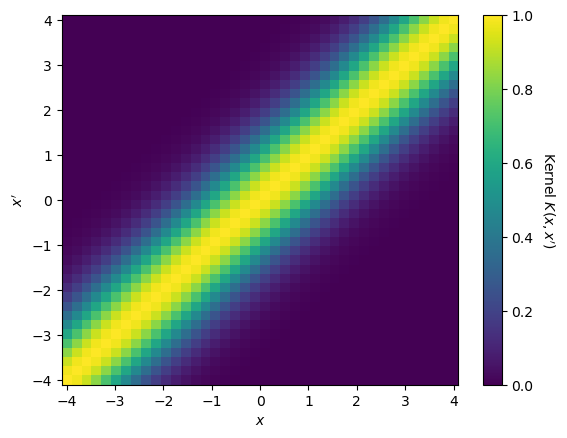

In [96]:
# EXAMPLE: Show the prior covariance. Remember this has mean f(x) = 0

# Sample from the Gaussian process distribution
n_of_samples = 40  # number of points in each function
sigma = 1
ell = 1

# Space to sample
X = np.expand_dims(np.linspace(-4, 4, n_of_samples), 1)
cov = SE_kernel(X, X, sigma, ell)  # Kernel of data points

#Create a meshgrid for the x and y axis
XX, YY = np.meshgrid(X, X)

plt.figure(dpi=100)
im = plt.pcolormesh(XX,YY,cov)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r"Kernel $K(x,x')$", rotation=-90, va="bottom")

plt.xlabel(r"$x$")
plt.ylabel(r"$x'$")

plt.show()

In [97]:
# EXAMPLE: Sample some functions from Gaussian process distribution
n_of_functions = 5  # Number of functions to sample

# Draw samples from the prior at our data points
# Assume mean of 0 for prior
ys = np.random.multivariate_normal(
    mean=np.zeros(n_of_samples), cov=cov, 
    size=n_of_functions)


Text(0.5, 0, 'x')

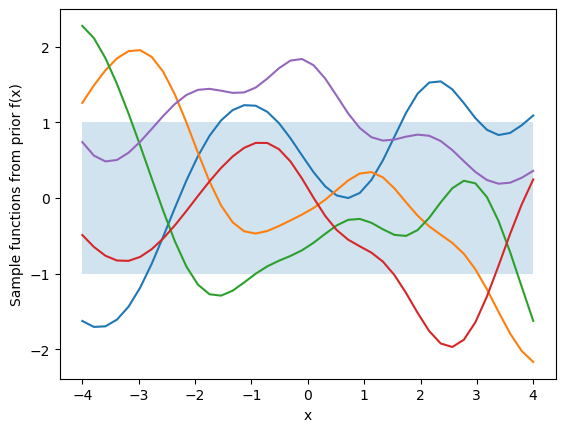

In [98]:
# EXAMPLE: Plot the sampled functions

for i in range(len(ys)):
    plt.plot(X, ys[i])

plt.fill_between(X.flatten(), -sigma, sigma, alpha=0.2)

plt.ylabel("Sample functions from prior f(x)")
plt.xlabel("x")

In [ ]:
# EXAMPLE: To Do - find corner plot showing marginal Gaussians, dimensions (n x n)



In [61]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    K11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    K12 = kernel_func(X1, X2)
    # Solve - returns (K11^-1 * K12)^T, assuming positive definite solutions
    solved = scipy.linalg.solve(K11, K12, assume_a='pos').T
    # Compute posterior mean
    mean2 = solved @ y1
    # Compute the posterior covariance
    K22 = kernel_func(X2, X2)
    K2 = K22 - (solved @ K12)
    return mean2, K2  # mean, covariance

In [87]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 5  # Number of points to condition on (training points)
n2 = 41  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior


# Sample observations (X1, y1) on the function
X1 = np.random.uniform(-5, 5, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(-6, 6, n2).reshape(-1, 1)

# Compute posterior mean and covariance
mean2, variance2 = GP(X1, y1, X2, lambda x, y: SE_kernel(x, y, sigma, ell))
# Compute the standard deviation at the test points to be plotted
stand_dev2 = np.sqrt(np.diag(variance2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=mean2, cov=variance2, size=ny)

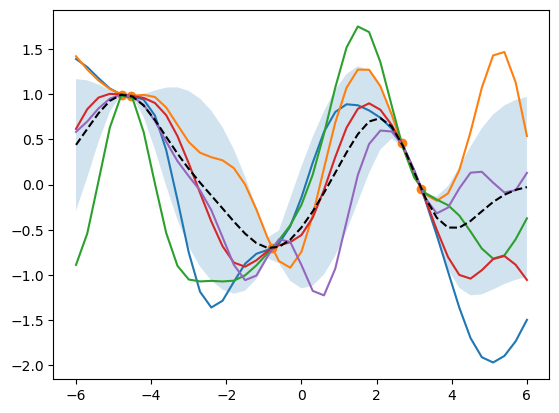

In [88]:
# EXAMPLE: plots for some sample posterior functions

for i in range(len(y2)):
    plt.plot(X2.flatten(), y2[i])
    
plt.plot(X2,mean2, "k--")
plt.fill_between(X2.flatten(), mean2-stand_dev2, mean2+stand_dev2, alpha=0.2)

plt.scatter(X1.flatten(),y1)

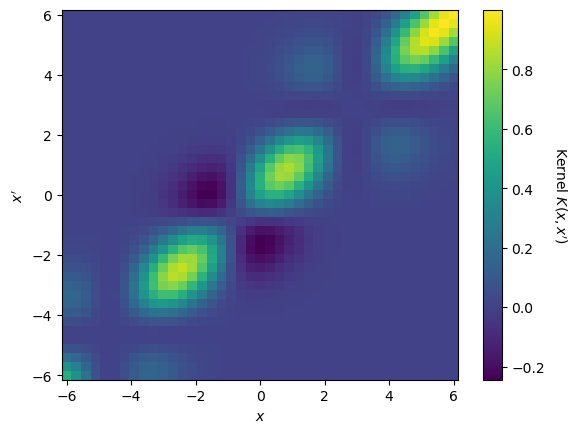

In [89]:
# EXAMPLE: Show the posterior covariance.

# Space to sample
X = np.expand_dims(np.linspace(-6, 6, n2), 1)

#Create a meshgrid for the x and y axis
XX, YY = np.meshgrid(X, X)

plt.figure(dpi=100)
im = plt.pcolormesh(XX,YY,variance2)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r"Kernel $K(x,x')$", rotation=-90, va="bottom")

plt.xlabel(r"$x$")
plt.ylabel(r"$x'$")

plt.show()